In [1]:
from google.colab import files
uploaded = files.upload()


Saving images.zip to images.zip


In [2]:
import zipfile

with zipfile.ZipFile("images.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

!ls /content


images	images.zip  sample_data


In [3]:
!ls /content/images


dalmatian  dollar_bill	pizza  soccer_ball  sunflower


In [5]:
def load_images(data_dir, img_size=(64, 64)):
    X = []
    y = []
    class_names = sorted(os.listdir(data_dir))

    for label_idx, class_name in enumerate(class_names):
        class_folder = os.path.join(data_dir, class_name)
        ...


In [7]:
import os
import numpy as np
from PIL import Image

def load_images(data_dir, img_size=(64, 64)):
    """
    Load images from directory:

    data_dir/
        class1/
        class2/
    """
    X = []
    y = []
    class_names = sorted(os.listdir(data_dir))
    print("Detected classes:", class_names)

    for label_idx, class_name in enumerate(class_names):
        class_folder = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_folder):
            continue

        for file_name in os.listdir(class_folder):
            if not file_name.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            file_path = os.path.join(class_folder, file_name)

            try:
                img = Image.open(file_path).convert("RGB")
                img = img.resize(img_size)
                img_array = np.array(img, dtype=np.float32) / 255.0
                X.append(img_array.flatten())
                y.append(label_idx)
            except Exception as e:
                print("Error loading:", file_path, e)

    X = np.array(X)
    y = np.array(y)

    print("X shape:", X.shape)
    print("y shape:", y.shape)

    return X, y, class_names


In [8]:
data_dir = "/content/images"

X, y, class_names = load_images(data_dir, img_size=(64, 64))

print("Classes:", class_names)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Detected classes: ['dalmatian', 'dollar_bill', 'pizza', 'soccer_ball', 'sunflower']
X shape: (309, 12288)
y shape: (309,)
Classes: ['dalmatian', 'dollar_bill', 'pizza', 'soccer_ball', 'sunflower']


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

print("Best RF parameters:", grid_search_rf.best_params_)

best_rf = grid_search_rf.best_estimator_


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best RF parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [10]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred_rf = best_rf.predict(X_test)

# Metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
rec_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

print("Random Forest Performance:")
print(f"Accuracy : {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall   : {rec_rf:.4f}")
print(f"F1-score : {f1_rf:.4f}\n")

print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf,
                            target_names=class_names,
                            zero_division=0))


Random Forest Performance:
Accuracy : 0.6613
Precision: 0.6719
Recall   : 0.6613
F1-score : 0.6531

Classification Report (Random Forest):
              precision    recall  f1-score   support

   dalmatian       0.53      0.57      0.55        14
 dollar_bill       0.77      1.00      0.87        10
       pizza       0.80      0.40      0.53        10
 soccer_ball       0.50      0.55      0.52        11
   sunflower       0.76      0.76      0.76        17

    accuracy                           0.66        62
   macro avg       0.67      0.66      0.65        62
weighted avg       0.67      0.66      0.65        62



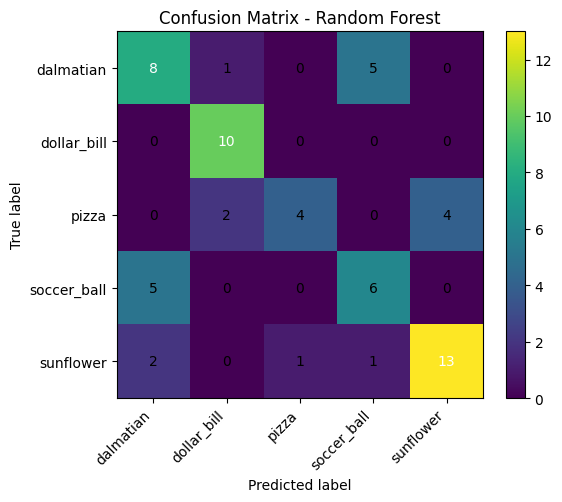

In [11]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
plt.imshow(cm_rf, interpolation="nearest")
plt.title("Confusion Matrix - Random Forest")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

thresh = cm_rf.max() / 2.0
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        plt.text(j, i, cm_rf[i, j],
                 ha="center", va="center",
                 color="white" if cm_rf[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


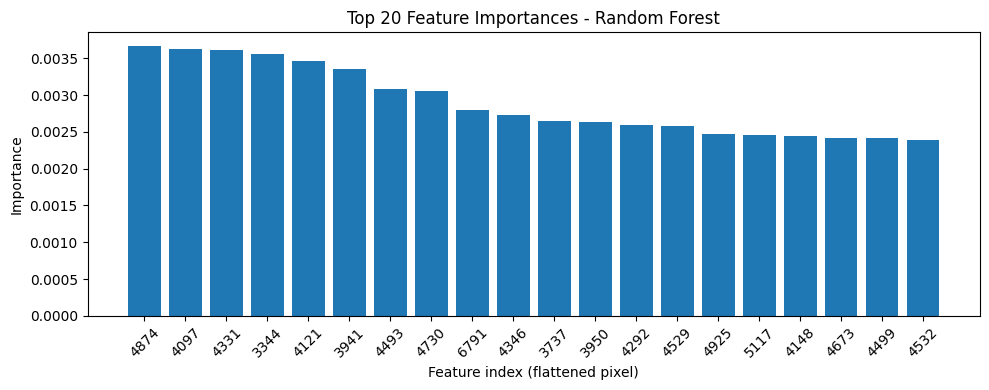

In [12]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]  # sort descending

top_k = 20  # show top 20 pixels/features

plt.figure(figsize=(10, 4))
plt.bar(range(top_k), importances[indices[:top_k]])
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Feature index (flattened pixel)")
plt.ylabel("Importance")
plt.xticks(range(top_k), indices[:top_k], rotation=45)
plt.tight_layout()
plt.show()


In [18]:
predicted_class = predict_image_class_rf(best_rf, class_names)


Saving image_0001.jpg to image_0001.jpg
Uploaded: image_0001.jpg
Predicted class (Random Forest): soccer_ball


In [19]:
from google.colab import files
from PIL import Image
import numpy as np

# ---- helper to preprocess ONE image ----
def preprocess_single_image(img_path, img_size=(64, 64)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(img_size)
    img_array = np.array(img, dtype=np.float32) / 255.0   # normalize
    return img_array.flatten().reshape(1, -1)             # shape (1, 12288)

# ---- function that uploads + predicts in one go ----
def predict_image_class_rf(model, class_names, img_size=(64, 64)):
    # upload file
    uploaded = files.upload()
    if len(uploaded) == 0:
        print("No file uploaded.")
        return None

    img_path = list(uploaded.keys())[0]
    print("Uploaded:", img_path)

    # preprocess and predict
    x_new = preprocess_single_image(img_path, img_size)
    pred_idx = model.predict(x_new)[0]
    pred_class = class_names[pred_idx]
    print("Predicted class (Random Forest):", pred_class)
    return pred_class

# ---- call it ----
predicted_class = predict_image_class_rf(best_rf, class_names)


Saving image_0001.jpg to image_0001 (1).jpg
Uploaded: image_0001 (1).jpg
Predicted class (Random Forest): soccer_ball
